In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from datasets import load_dataset
from PIL import Image
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torcheval.metrics import MulticlassAccuracy
from torchvision import datasets, transforms

import wandb


## Data Loading


In [2]:
# set up the transform to resize the images
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

batch_size = 64

# get labels from folder names
dataset = datasets.ImageFolder(root="data", transform=transform)

# create random train test split from data
rand_generator = torch.Generator().manual_seed(42)
train_dataaset, test_dataset = random_split(
    dataset, [0.8, 0.2], generator=rand_generator
)
print(f"{len(train_dataaset)} training images")
print(f"{len(test_dataset)} testing images")

train_dataloader = DataLoader(train_dataaset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


4493 training images
1123 testing images


In [3]:
# show the encoding for each class label
class_to_idx = dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
print(idx_to_class)

{0: 'afghan', 1: 'chinese', 2: 'indian', 3: 'modern', 4: 'moroccan', 5: 'persian', 6: 'turkish'}


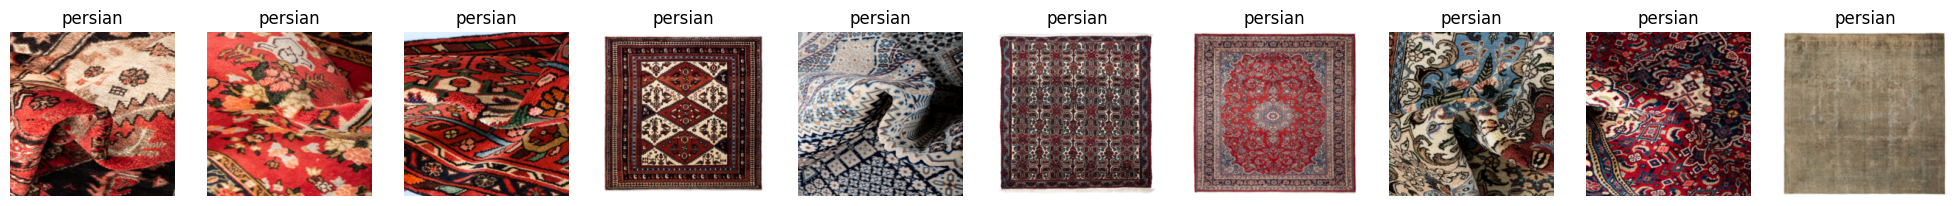

In [4]:
# convert tensor to numpy and plot as image
def imshow(image, ax=None, title=None) -> None:
    if ax is None:
        fig, ax = plt.subplots()
    # unnormalize the image
    image = image / 2 + 0.5
    image = image.numpy().transpose((1, 2, 0))
    ax.imshow(image)
    if title is not None:
        ax.set_title(title)
    ax.axis("off")


# plot training images
images, labels = next(iter(train_dataloader))
fig, axes = plt.subplots(1, 10, figsize=(25, 25))
for i in range(10):
    class_name = idx_to_class[int(labels[i])]
    imshow(images[i], ax=axes[i], title=class_name)
plt.show()


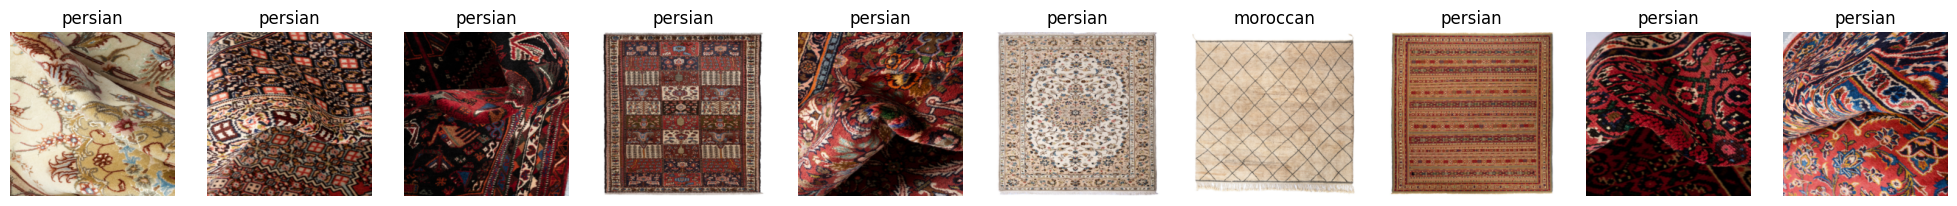

In [5]:
# plot test images
images, labels = next(iter(test_dataloader))
fig, axes = plt.subplots(1, 10, figsize=(25, 25))
for i in range(10):
    class_name = idx_to_class[int(labels[i])]
    imshow(images[i], ax=axes[i], title=class_name)
plt.show()

In [6]:
from collections import Counter

# Initialize a Counter to count instances
label_counts = Counter()

# Loop over the DataLoader to get the labels
for _, labels in train_dataloader:
    label_counts.update(labels.tolist())

# Convert the dataset class indices to class names
class_to_idx = dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Print the counts for each class
for label, count in label_counts.items():
    class_name = idx_to_class[label]
    print(f"Class {class_name} has {count} instances")


Class persian has 3257 instances
Class moroccan has 359 instances
Class modern has 378 instances
Class afghan has 190 instances
Class turkish has 127 instances
Class chinese has 79 instances
Class indian has 103 instances


In [7]:
from collections import Counter

# Initialize a Counter to count instances
label_counts = Counter()

# Loop over the DataLoader to get the labels
for _, labels in test_dataloader:
    label_counts.update(labels.tolist())

# Convert the dataset class indices to class names
class_to_idx = dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Print the counts for each class
for label, count in label_counts.items():
    class_name = idx_to_class[label]
    print(f"Class {class_name} has {count} instances")

Class persian has 829 instances
Class turkish has 26 instances
Class moroccan has 75 instances
Class afghan has 48 instances
Class modern has 102 instances
Class indian has 18 instances
Class chinese has 25 instances


## Model


In [8]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")


class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(dataset.class_to_idx))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


model = NeuralNetwork().to(device)

Using mps device


In [9]:
class NeuralNetworkWithDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, len(dataset.class_to_idx))

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return self.fc3(x)


model = NeuralNetworkWithDropout().to(device)

## Optimizer, loss and accuracy


In [ ]:
# implement focal loss to address the class imbalance
class FocalLoss(nn.Module):
    """Implement focal loss to address the class imbalance in the data. Focal loss
    will adjust the loss by giving a higher weight to samples with lower probability
    of being correctly classified.

    https://arxiv.org/pdf/1708.02002
    https://pytorch.org/vision/stable/_modules/torchvision/ops/focal_loss.html
    """

    def __init__(self, alpha=1, gamma=2, reduction="mean"):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.name = "Focal Loss"

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction="none")
        # prevent NaNs when probability is 0 by computing probability of true class
        prob_true = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - prob_true) ** self.gamma * BCE_loss

        if self.reduction == "none":
            pass
        elif self.reduction == "mean":
            return torch.mean(F_loss)
        elif self.reduction == "sum":
            return torch.sum(F_loss)
        else:
            msg = f"An invalid value was selected for arg 'reduction': {self.reduction} \n Supported reduction values: 'none', 'mean', 'sum'"
            raise ValueError(msg)


focal_loss = FocalLoss(alpha=0.25, gamma=2)

In [11]:
learning_rate = 0.02
# loss_fn = nn.CrossEntropyLoss()
loss_fn = focal_loss
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [16]:
def get_loss_fn_params(loss_fn):
    # Extract alpha, gamma, and reduction parameters from the loss function, if available
    params = {}
    for attr in ["alpha", "gamma", "reduction"]:
        if hasattr(loss_fn, attr):
            params[attr] = getattr(loss_fn, attr)
    return params


def initialize_wandb(model, train_dataloader, learning_rate, epochs, loss_fn, patience):
    config = {
        "learning_rate": learning_rate,
        "architecture": model.__class__.__name__,
        "dataset": "rugs",
        "epochs": epochs,
        "batch_size": train_dataloader.batch_size,
        "loss_function": loss_fn.__class__.__name__,
        "patience": patience,
    }

    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            config[name] = {
                "in_channels"
                if isinstance(module, nn.Conv2d)
                else "in_features": module.in_channels
                if isinstance(module, nn.Conv2d)
                else module.in_features,
                "out_channels"
                if isinstance(module, nn.Conv2d)
                else "out_features": module.out_channels
                if isinstance(module, nn.Conv2d)
                else module.out_features,
            }
        if isinstance(module, nn.Dropout):
            config[f"{name}_dropout_rate"] = module.p

    loss_fn_params = get_loss_fn_params(loss_fn)
    config.update(loss_fn_params)

    wandb.init(
        project="rugai",
        config=config,
    )

## Training


In [18]:
def train_model(
    train_dataloader,
    test_dataloader,
    model,
    loss_fn,
    optimizer,
    epochs,
    class_to_idx,
    learning_rate,
    patience,
):
    initialize_wandb(
        model,
        train_dataloader,
        learning_rate=learning_rate,
        epochs=epochs,
        loss_fn=loss_fn,
        patience=patience,
    )
    config = wandb.config

    best_accuracy = 0.0
    accuracy = MulticlassAccuracy(num_classes=len(class_to_idx), average="macro")
    epochs_without_improvement = 0

    for epoch in range(config.epochs):
        model.train()
        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            wandb.log({"loss": loss.item()})

        # now check accuracy after epoch against train dataset
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                all_preds.append(preds)
                all_labels.append(labels)

        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        accuracy.update(all_preds, all_labels)
        epoch_acc = accuracy.compute()

        wandb.log({"accuracy": epoch_acc.item()})

        if epoch_acc > best_accuracy:
            best_accuracy = epoch_acc
            epochs_without_improvement = 0
            model_path = f"model/models/model_best_epoch_{epoch + 1}.pth"
            torch.save(model.state_dict(), model_path)
            print(f"New best model saved with accuracy: {epoch_acc:.4f}")

            # Log the saved model as an artifact
            artifact = wandb.Artifact("best_model", type="model")
            artifact.add_file(model_path)
            wandb.log_artifact(artifact)

        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered after {epoch + 1} epochs")
                break

        print(f"Epoch {epoch + 1}/{config.epochs}, Accuracy: {epoch_acc:.4f}")

    wandb.finish()
    print("Training completed.")

    return model


trained_model = train_model(
    train_dataloader,
    test_dataloader,
    model,
    loss_fn,
    optimizer,
    epochs=2,
    class_to_idx=class_to_idx,
    learning_rate=learning_rate,
    patience=0,
)

New best model saved with accuracy: 0.4396
Epoch 1/2, Accuracy: 0.4396
New best model saved with accuracy: 0.4668
Epoch 2/2, Accuracy: 0.4668


wandb: ERROR Control-C detected -- Run data was not synced


KeyboardInterrupt: 

## Testing


In [69]:
# Assuming class_to_idx is already defined
class_to_idx = dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Set the model to evaluation mode
model.eval()

# Retrieve a single image and label from the test dataloader
images, labels = next(iter(test_dataloader))
images, labels = images.to(device), labels.to(device)

# Make a prediction
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Print the predicted label for the first image
image = images[0]
predicted_label = preds[0].item()
true_label = labels[0].item()

print(f"Predicted: {idx_to_class[predicted_label]}, True: {idx_to_class[true_label]}")

Predicted: persian, True: persian


## Predict on single image


In [66]:
# Assuming class_to_idx and your model are already defined
class_to_idx = dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}


# Load an arbitrary image
def load_image(image_path):
    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add a batch dimension
    return image


# Predict the class for the given image
def predict_image_class(image_path, model):
    image = load_image(image_path).to(device)
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        predicted_class = predicted.item()
        class_name = idx_to_class[predicted_class]
        return class_name


# Example usage
image_path = "predict/IMG_2341.jpg"
predicted_class_name = predict_image_class(image_path, model)
print(f"The predicted class for the image is: {predicted_class_name}")

The predicted class for the image is: persian


### Evaluation of Test Data


Precision: 0.8628
Recall: 0.6837
F1 Score: 0.7381
Class afghan - FPR: 0.0037, Recall: 0.5208
Class chinese - FPR: 0.0000, Recall: 0.4800
Class indian - FPR: 0.0018, Recall: 0.2222
Class modern - FPR: 0.0108, Recall: 0.9020
Class moroccan - FPR: 0.0057, Recall: 0.9467
Class persian - FPR: 0.1905, Recall: 0.9831
Class turkish - FPR: 0.0055, Recall: 0.7308


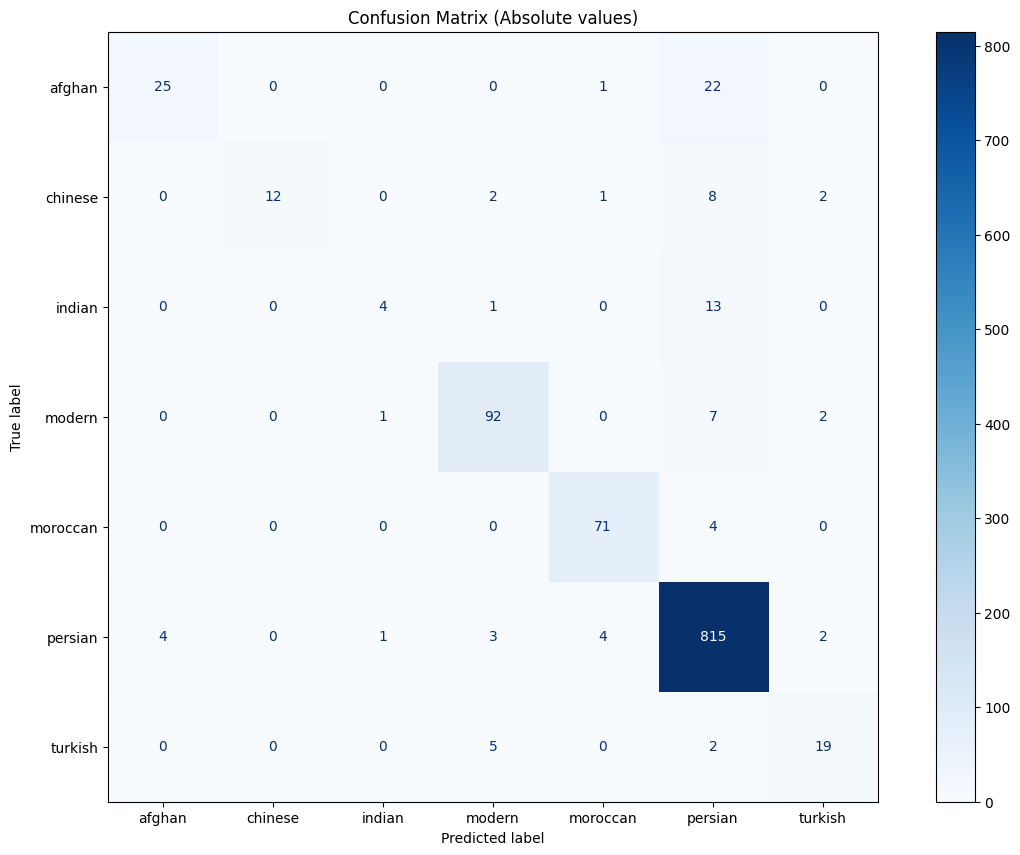

In [79]:
def get_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_preds, all_labels


# Generate predictions
all_preds, all_labels = get_predictions(model, test_dataloader, device)

# Calculate precision, recall, and f1 scores
precision = precision_score(all_labels, all_preds, average="macro")
recall = recall_score(all_labels, all_preds, average="macro")
f1 = f1_score(all_labels, all_preds, average="macro")

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Calculate False Positive Rate for each class
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# False Positive Rate: FP / (FP + TN)
FPR = FP / (FP + TN)

# Recall: TP / (TP + FN)
Recall = TP / (TP + FN)

for i, fpr in enumerate(FPR):
    class_name = list(class_to_idx.keys())[i]
    print(f"Class {class_name} - FPR: {FPR[i]:.4f}, Recall: {Recall[i]:.4f}")

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=list(class_to_idx.keys())
)
fig, ax = plt.subplots(figsize=(15, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix (Absolute values)")
plt.show()


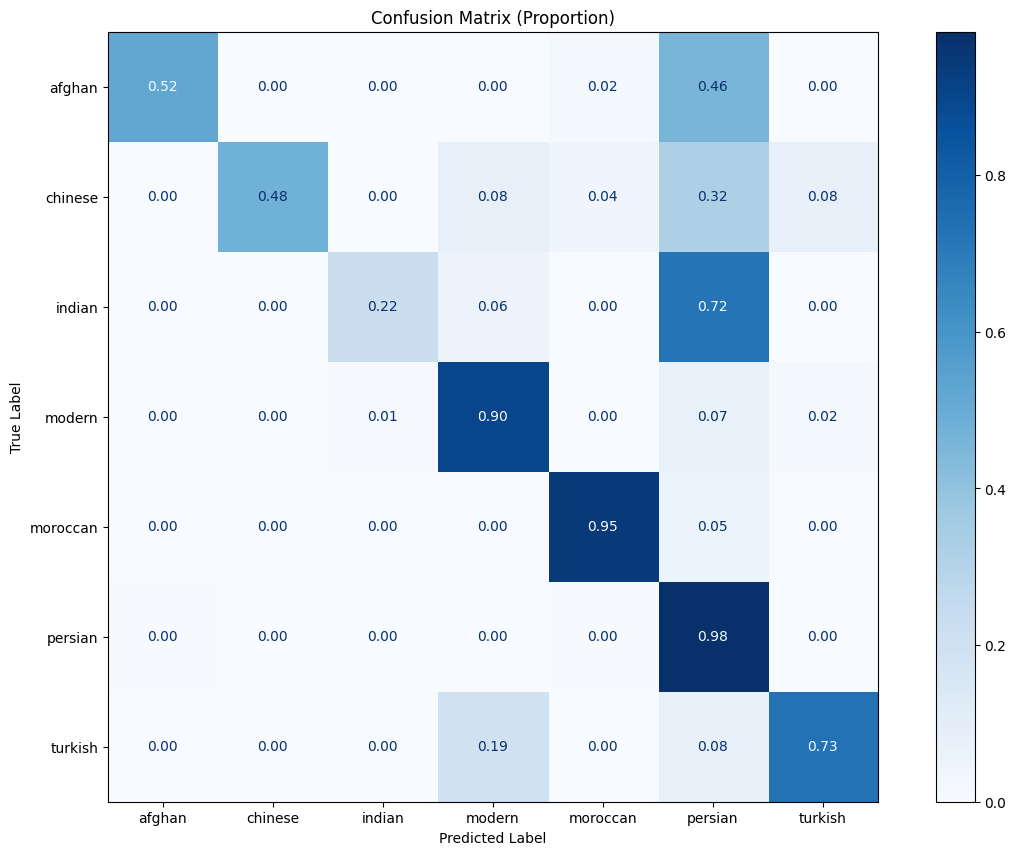

In [78]:
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(15, 10))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_normalized, display_labels=list(class_to_idx.keys())
)
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=".2f")
plt.title("Confusion Matrix (Proportion)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()
